# NETWORK LSTM MODEL MULTIVARIADO - MULTISTEP

# 0.- Setup library

In [24]:
!pip3 install pandas matplotlib numpy tensorflow


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
!pip3 list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
aiofiles                     23.2.1
altair                       5.1.1
annotated-types              0.5.0
anyio                        3.7.1
asttokens                    2.4.0
astunparse                   1.6.3
attrs                        23.1.0
Augmentor                    0.2.12
backcall                     0.2.0
blinker                      1.6.2
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
click                        8.1.7
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.11.0
debugpy                      1.8.0
decorator                    5.1.1
exceptiongroup               1.1.3
executing                    1.2.0
fastapi                      0.103.1
ffmpy                        0.3.1
filelock                     3.12.4



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1.-Import library

In [26]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# 2.- Data processing 

### 2.1.- Load dataframe

In [27]:
df = pd.read_csv('2017-2023_preprocesado.csv', index_col='Timesteps')

### 2.2.- Data visualization(Df)

In [28]:
df = df.reset_index()
df = df.drop(columns=['Timesteps'])
df

,Unnamed: 0,bx_gsm,by_gsm,bz_gsm,bt,Kp
0,0,-4.384540,0.151482,-2.747153,5.864738,3.333
1,1,-2.083439,-0.208964,-2.461775,5.662317,3.667
2,2,-1.154902,0.917093,-1.160736,4.204290,2.667
3,3,-0.272552,-0.552822,-0.523117,4.356062,2.333
4,4,1.430231,2.103350,-0.312276,4.290185,2.333
...,...,...,...,...,...,...
13918,13918,-1.010831,2.140212,4.917626,5.530442,1.667
13919,13919,-0.821487,2.506119,4.728662,5.517849,1.333
13920,13920,-1.122956,3.178282,4.084596,5.360607,2.000
13921,13921,0.477437,2.309392,-2.623546,4.183323,2.000


In [29]:
df= df.drop(columns=['Unnamed: 0'])

In [30]:
df

,bx_gsm,by_gsm,bz_gsm,bt,Kp
0,-4.384540,0.151482,-2.747153,5.864738,3.333
1,-2.083439,-0.208964,-2.461775,5.662317,3.667
2,-1.154902,0.917093,-1.160736,4.204290,2.667
3,-0.272552,-0.552822,-0.523117,4.356062,2.333
4,1.430231,2.103350,-0.312276,4.290185,2.333
...,...,...,...,...,...
13918,-1.010831,2.140212,4.917626,5.530442,1.667
13919,-0.821487,2.506119,4.728662,5.517849,1.333
13920,-1.122956,3.178282,4.084596,5.360607,2.000
13921,0.477437,2.309392,-2.623546,4.183323,2.000


### 2.3.- Data split

In [31]:
# Función para generar las particiones preservando las características de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (11138, 5)
Tamaño set de validación: (1392, 5)
Tamaño set de prueba: (1393, 5)


### 2.4.- Graphic representation of the data split

*In the variable 'covar', you should input the number of covariates accompanying our target variables to predict (in this case, Kp).*

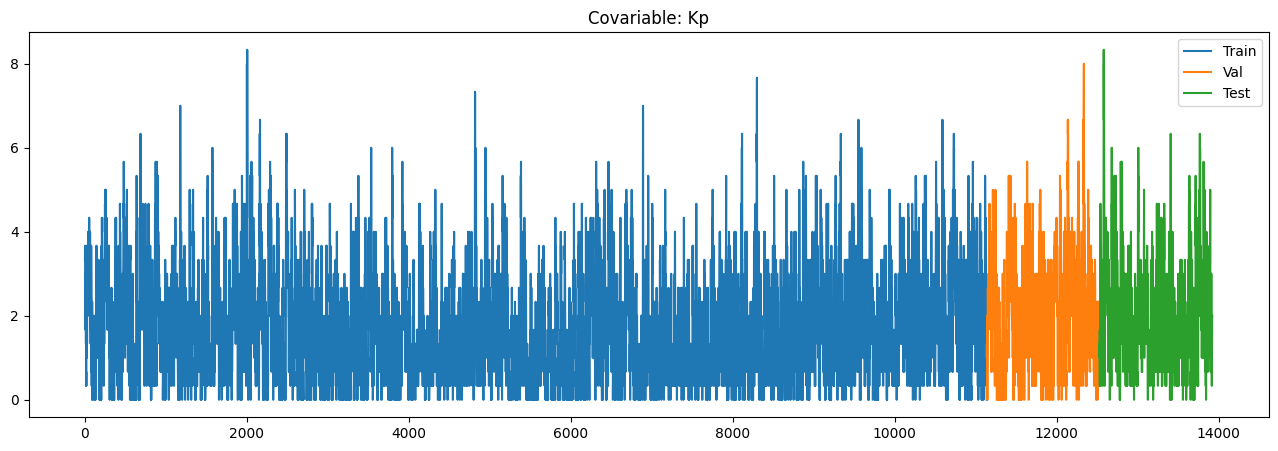

In [32]:
covar = 4 
col = df.columns[covar]

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

### 2.5.- create supervised dataset

In [33]:
def create_supervised_dataset(array, input_length, output_length):
    X, Y = [], []    
    shape = array.shape
    if len(shape)==1: 
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: 
        fils, cols = array.shape

    
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

### 2.6.- 

In [35]:
INPUT_LENGTH = 8  
OUTPUT_LENGTH = 8 

x_tr, y_tr = create_supervised_dataset(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = create_supervised_dataset(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = create_supervised_dataset(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (11122, 8, 5), y_tr: (11122, 8, 1)
Set de validación - x_vl: (1376, 8, 5), y_vl: (1376, 8, 1)
Set de prueba - x_ts: (1377, 8, 5), y_ts: (1377, 8, 1)


In [36]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    col_ref = df.columns.get_loc(col_ref)

    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)


    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [37]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

data_s, scaler = escalar_dataset(data_in, col_ref = 'Kp' )

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

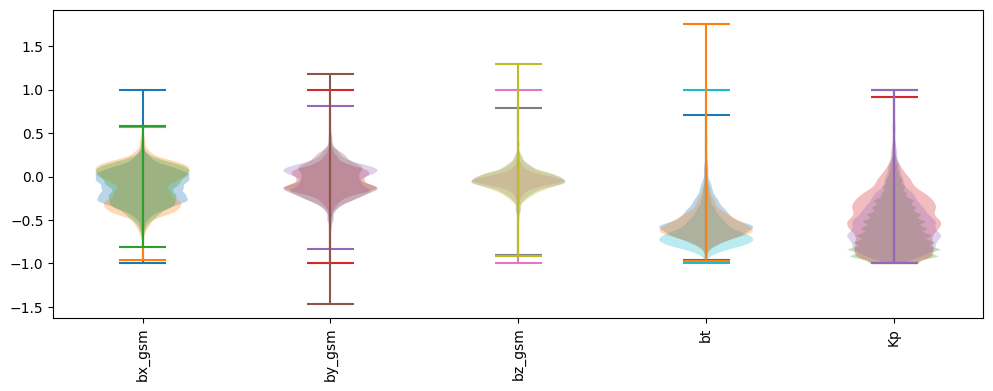

In [38]:
fig, ax = plt.subplots(figsize=(12,4))
for i in range(5):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

ax.set_xticks(list(range(5)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

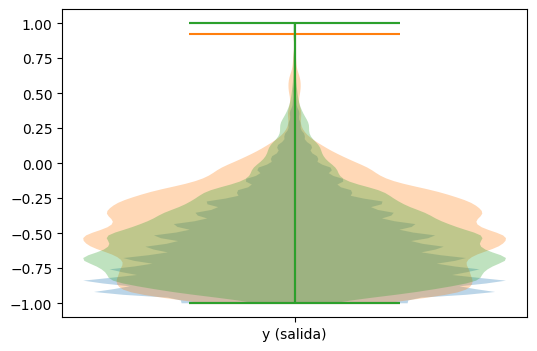

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

In [40]:
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

In [41]:
N_UNITS =  128 
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 8 (24horas) x 5 (features)


In [42]:
modelo = Sequential([
    LSTM(N_UNITS, input_shape=INPUT_SHAPE),
    Dense(64, activation='linear'),
    
    Dense(OUTPUT_LENGTH, activation='linear')
])

In [43]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [44]:
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

In [108]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               68608     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 77,384
Trainable params: 77,384
Non-trainable params: 0
_________________________________________________________________


In [84]:
#El entrenamiento dura 2:10 min
EPOCHS = 100 
BATCH_SIZE = 64 
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100
174/174 - 4s - loss: 0.5101 - val_loss: 0.2995 - 4s/epoch - 21ms/step
Epoch 2/100
174/174 - 1s - loss: 0.2749 - val_loss: 0.2904 - 1s/epoch - 7ms/step
Epoch 3/100
174/174 - 1s - loss: 0.2707 - val_loss: 0.2861 - 1s/epoch - 8ms/step
Epoch 4/100
174/174 - 1s - loss: 0.2678 - val_loss: 0.2834 - 1s/epoch - 8ms/step
Epoch 5/100
174/174 - 1s - loss: 0.2655 - val_loss: 0.2801 - 1s/epoch - 7ms/step
Epoch 6/100
174/174 - 1s - loss: 0.2636 - val_loss: 0.2792 - 1s/epoch - 7ms/step
Epoch 7/100
174/174 - 1s - loss: 0.2619 - val_loss: 0.2766 - 1s/epoch - 7ms/step
Epoch 8/100
174/174 - 1s - loss: 0.2604 - val_loss: 0.2752 - 1s/epoch - 7ms/step
Epoch 9/100
174/174 - 1s - loss: 0.2592 - val_loss: 0.2732 - 1s/epoch - 7ms/step
Epoch 10/100
174/174 - 1s - loss: 0.2580 - val_loss: 0.2727 - 1s/epoch - 7ms/step
Epoch 11/100
174/174 - 1s - loss: 0.2571 - val_loss: 0.2738 - 1s/epoch - 8ms/step
Epoch 12/100
174/174 - 1s - loss: 0.2564 - val_loss: 0.2694 - 1s/epoch - 7ms/step
Epoch 13/100
174/174 - 1

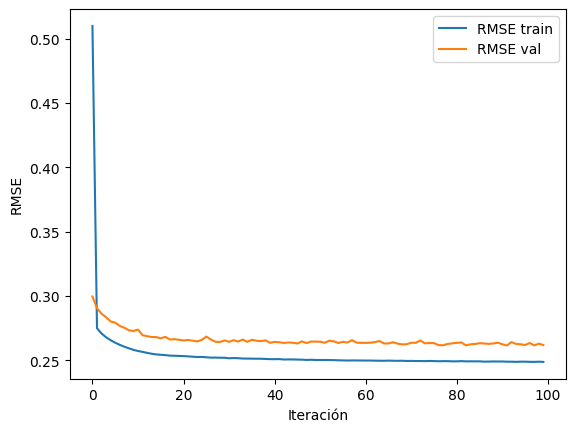

In [85]:
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [86]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.241
  RMSE val:	 0.260
  RMSE test:	 0.256


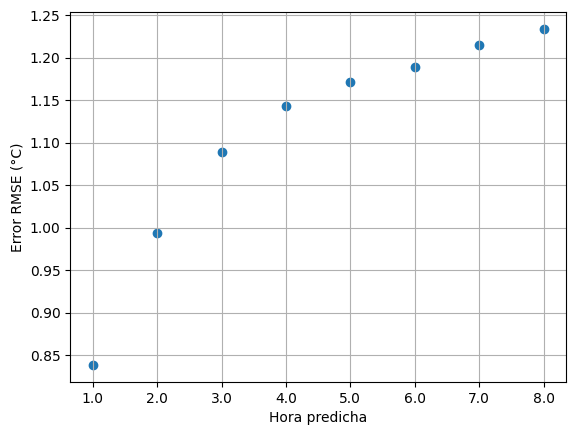

In [100]:
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) 
proms = np.mean(diff_cuad, axis=0) 
rmse = np.sqrt(proms) 

t = np.linspace(1,8,8)

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE (°C)')
plt.xticks(ticks=t, labels=t)
plt.grid();

In [97]:
modelo.save("lstm_modelo.h5")

In [45]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

LSTM_model = tf.keras.models.load_model('lstm_modelo.h5',custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [46]:
y_ts_pred_s = LSTM_model.predict(x_ts_s, verbose=0)

y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) 
proms = np.mean(diff_cuad, axis=0)

In [47]:
df2=pd.read_csv('2017-2023_preprocesado.csv')

In [48]:
ultima_fila = df2.tail(1)
df2.drop(columns=['Unnamed: 0'])

,Timesteps,bx_gsm,by_gsm,bz_gsm,bt,Kp
0,2017-01-01 00:00:00,-4.384540,0.151482,-2.747153,5.864738,3.333
1,2017-01-01 03:00:00,-2.083439,-0.208964,-2.461775,5.662317,3.667
2,2017-01-01 06:00:00,-1.154902,0.917093,-1.160736,4.204290,2.667
3,2017-01-01 09:00:00,-0.272552,-0.552822,-0.523117,4.356062,2.333
4,2017-01-01 12:00:00,1.430231,2.103350,-0.312276,4.290185,2.333
...,...,...,...,...,...,...
13918,2023-10-07 03:00:00,-1.010831,2.140212,4.917626,5.530442,1.667
13919,2023-10-07 06:00:00,-0.821487,2.506119,4.728662,5.517849,1.333
13920,2023-10-07 09:00:00,-1.122956,3.178282,4.084596,5.360607,2.000
13921,2023-10-07 12:00:00,0.477437,2.309392,-2.623546,4.183323,2.000


In [49]:
ultima_fecha_str = ultima_fila['Timesteps'].values[0]

ultima_fecha_dt = datetime.strptime(ultima_fecha_str, '%Y-%m-%d %H:%M:%S')


fechas_resultantes = []
date_predictions=[]

for _ in range(8):  
    ultima_fecha_dt += timedelta(hours=3)
    fechas_resultantes.append(ultima_fecha_dt)

fechas_resultantes_str = [fecha.strftime('%Y-%m-%d %H:%M:%S') for fecha in fechas_resultantes]

for fecha in fechas_resultantes_str:
    date_predictions.append(fecha)

In [50]:
data = {'Timesteps': fechas_resultantes, 'kp': proms}
df_predictions = pd.DataFrame(data)

In [52]:
df_predictions

,Timesteps,kp
0,2023-10-07 18:00:00,0.703025
1,2023-10-07 21:00:00,0.988319
2,2023-10-08 00:00:00,1.184759
3,2023-10-08 03:00:00,1.306326
4,2023-10-08 06:00:00,1.371049
5,2023-10-08 09:00:00,1.413816
6,2023-10-08 12:00:00,1.475416
7,2023-10-08 15:00:00,1.522457


In [53]:
df_predictions.to_csv('df_predictions.csv')